## Lila and Gabby: Regression {-}


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [18]:
#Lila's filepath for the movie dataset
#movies = pd.read_csv('Desktop/STAT3032/movie_metadata.csv')

#Gabby's filepath for the movie dataset:
movies = pd.read_csv('movie_metadata.csv')

In [19]:
movies.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [20]:
movies['language'].value_counts()
#The majority of the movies are in English...but we could do a comparison of success based on english vs not english.

English       4704
French          73
Spanish         40
Hindi           28
Mandarin        26
German          19
Japanese        18
Cantonese       11
Russian         11
Italian         11
Portuguese       8
Korean           8
Arabic           5
Danish           5
Hebrew           5
Swedish          5
Polish           4
Norwegian        4
Persian          4
Dutch            4
Thai             3
Chinese          3
Icelandic        2
None             2
Indonesian       2
Aboriginal       2
Romanian         2
Dari             2
Zulu             2
Panjabi          1
Urdu             1
Vietnamese       1
Slovenian        1
Greek            1
Dzongkha         1
Tamil            1
Telugu           1
Kannada          1
Czech            1
Hungarian        1
Bosnian          1
Filipino         1
Mongolian        1
Maya             1
Aramaic          1
Kazakh           1
Swahili          1
Name: language, dtype: int64

In [21]:
movies['plot_keywords'].value_counts()
#pick certain words that come up often... 'love', 'illegal','money', 'superhero'
#can we isolate each word, and then find the value counts from there?

string = "one,two,three"
words = string.split(',')
words

['one', 'two', 'three']

In [22]:
keywords_list = movies['plot_keywords'].to_list()
len(keywords_list)

list_of_lists = []
for i in range(5043):
    if type(keywords_list[i])== str:
        z = keywords_list[i].split('|')
        list_of_lists.append(z)
#this returns a lists of lists, containing all of the keywords separately

list_of_keywords = []
for i in list_of_lists:
    for j in i:
        list_of_keywords.append(j)
#this new list is a list of every single keyword in the dataframe. Now let's see which ones are the most common

df_of_keywords = pd.DataFrame(list_of_keywords)
df_of_keywords.value_counts()

#these are the most popular keywords. We will do something with them

love                       198
friend                     166
murder                     161
death                      132
police                     126
                          ... 
high society                 1
high school sweethearts      1
high school romance          1
high school prom             1
lightning bolt               1
Length: 8086, dtype: int64

In [23]:
movies['genres']
#we should simplify this variable... as there are many different combos

0       Action|Adventure|Fantasy|Sci-Fi
1              Action|Adventure|Fantasy
2             Action|Adventure|Thriller
3                       Action|Thriller
4                           Documentary
                     ...               
5038                       Comedy|Drama
5039       Crime|Drama|Mystery|Thriller
5040              Drama|Horror|Thriller
5041               Comedy|Drama|Romance
5042                        Documentary
Name: genres, Length: 5043, dtype: object

We want to initially explore what predictors should be used, regarding a regression model where gross is the response.

In [24]:
movies.shape
#5,043 movies, 28 variables

movies.head()

movies.corrwith(movies.gross).sort_values(ascending = True)

facenumber_in_poster        -0.027755
title_year                   0.030886
aspect_ratio                 0.069346
budget                       0.102179
director_facebook_likes      0.144945
actor_1_facebook_likes       0.154468
imdb_score                   0.198021
cast_total_facebook_likes    0.247400
duration                     0.250298
actor_2_facebook_likes       0.262768
actor_3_facebook_likes       0.308026
movie_facebook_likes         0.378082
num_critic_for_reviews       0.480601
num_user_for_reviews         0.559958
num_voted_users              0.637271
gross                        1.000000
dtype: float64

It seems like num_voted_users, num_user_for_reviews, and num_critic_for_reviews are the three variables with the highest correlation with gross. These variables are defined as:<br>
**num_voted_users:** The total number of users who interacted with the movie? <br>
**num_user_for_reviews:** The number of user reviews for a certain movie. <br>
**num_critic_for_reviews:** The number of critic reviews for a certain movie. <br>

These three variabes can not be used for prediction, as they are all measures recorded after a movie is already made, but can be used for inference purposes. 

<AxesSubplot:>

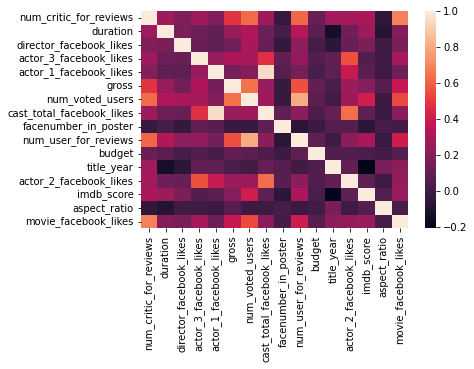

In [25]:
sns.heatmap(movies.corr())

### VIF for facebook likes

In [26]:
movies2 = movies.dropna()
movies2 = movies2.reset_index()

X = movies2[['actor_1_facebook_likes', 'actor_3_facebook_likes','actor_2_facebook_likes','director_facebook_likes','cast_total_facebook_likes', 'movie_facebook_likes']]
X.columns[1:]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                     feature         VIF
0                      const    1.694919
1     actor_1_facebook_likes  201.147594
2     actor_3_facebook_likes    8.353041
3     actor_2_facebook_likes   19.287085
4    director_facebook_likes    1.037344
5  cast_total_facebook_likes  303.215284
6       movie_facebook_likes    1.113454


<AxesSubplot:xlabel='movie_facebook_likes', ylabel='gross'>

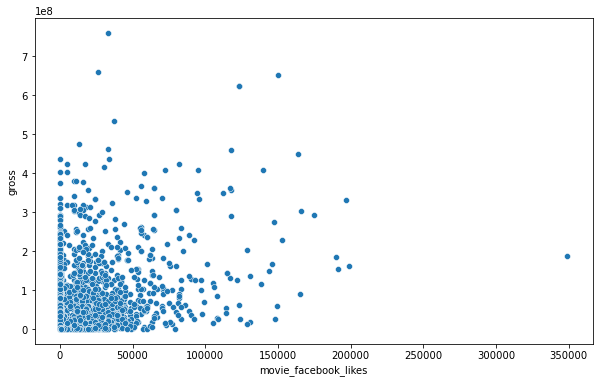

In [27]:
plt.rcParams["figure.figsize"] = (10,6)
sns.scatterplot(x ='movie_facebook_likes',y = 'gross',data = movies)

<AxesSubplot:xlabel='cast_total_facebook_likes', ylabel='gross'>

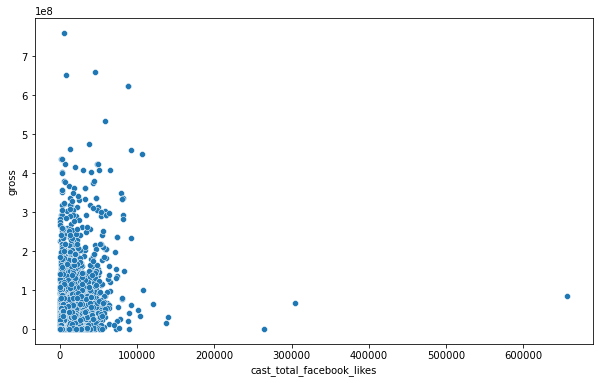

In [28]:
plt.rcParams["figure.figsize"] = (10,6)
sns.scatterplot(x ='cast_total_facebook_likes',y = 'gross',data = movies)

# Test and Train Data:

In [29]:
np.random.seed(2)

# 80% to be training
train = movies.sample(round(movies.shape[0]*.8))
# drop the train data from the test df
test = movies.drop(train.index)

In [30]:
test.budget.mean()

34218853.24752475

# Gab

### Model with just facebook_likes not associated with multicollinearity

In [31]:
model = smf.ols('gross~movie_facebook_likes+cast_total_facebook_likes+director_facebook_likes', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     236.1
Date:                Sat, 11 Mar 2023   Prob (F-statistic):          7.10e-139
Time:                        12:25:38   Log-Likelihood:                -64324.
No. Observations:                3323   AIC:                         1.287e+05
Df Residuals:                    3319   BIC:                         1.287e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.126e+07   1.29e+06     24.195      0.000    2.87e+07    3.38e+07
movie_facebook_likes       1154.2854     56.184     20.545      0.000    1044.126    1264.445
cast_total_facebook_likes   584.8123     56.825     10.291      0.000     473.396     696.228
director_facebook_likes    1980.6577    373.619      5.301      0.000    1248.110    2713.205
==============================================================================
Omnibus:                     1762.269   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16329.299
Skew:                           2.355   Prob(JB):                         0.00
Kurtosis:                      12.785   Cond. No.                     3.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
#MAE
predictions = model.predict(test)

#Computing MAE on test data
(np.abs(test.gross - predictions)).mean()

40075675.65587589

### Dummifying Genre Variables

In [33]:
import numpy as np

genres = movies.genres.str.split("|", expand = True)
gen = [] 
for x in range(genres.shape[1]):
    u = genres.iloc[:, x].unique()
    gen = gen + list(u)
    
genre_list = list(pd.DataFrame(gen).iloc[:, 0].unique())
genre_list.remove(None)
genre_list

['Action',
 'Documentary',
 'Adventure',
 'Drama',
 'Animation',
 'Comedy',
 'Mystery',
 'Fantasy',
 'Crime',
 'Biography',
 'Sci-Fi',
 'Horror',
 'Romance',
 'Thriller',
 'Game-Show',
 'Family',
 'Music',
 'Western',
 'Musical',
 'Film-Noir',
 'History',
 'War',
 'Sport',
 'Reality-TV',
 'Short',
 'News']

In [34]:
genre_list = ' '.join(genre_list).replace('-','_').split()
genre_list

['Action',
 'Documentary',
 'Adventure',
 'Drama',
 'Animation',
 'Comedy',
 'Mystery',
 'Fantasy',
 'Crime',
 'Biography',
 'Sci_Fi',
 'Horror',
 'Romance',
 'Thriller',
 'Game_Show',
 'Family',
 'Music',
 'Western',
 'Musical',
 'Film_Noir',
 'History',
 'War',
 'Sport',
 'Reality_TV',
 'Short',
 'News']

### Dummies for genres for test

In [35]:
for i in range(len(genre_list)):
    test[str(genre_list[i])] = test.genres.apply(lambda x: 1 if str(genre_list[i]) in x else 0)
test

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Music,Western,Musical,Film_Noir,History,War,Sport,Reality_TV,Short,News
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,0,0,0,0,0,0,0,0,0,0
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,0,0,0,0,0,0,0,0,0,0
10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Action|Adventure|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
16,Color,Andrew Adamson,258.0,150.0,80.0,201.0,Pierfrancesco Favino,22000.0,141614023.0,Action|Adventure|Family|Fantasy,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,Black and White,Jim Chuchu,6.0,60.0,0.0,4.0,Olwenya Maina,147.0,NaN,Drama,...,0,0,0,0,0,0,0,0,0,0
5023,Color,Daryl Wein,22.0,88.0,38.0,211.0,Heather Burns,331.0,76382.0,Romance,...,0,0,0,0,0,0,0,0,0,0
5025,Color,John Waters,73.0,108.0,0.0,105.0,Mink Stole,462.0,180483.0,Comedy|Crime|Horror,...,0,0,0,0,0,0,0,0,0,0
5032,Color,Ash Baron-Cohen,10.0,98.0,3.0,152.0,Stanley B. Herman,789.0,NaN,Crime|Drama,...,0,0,0,0,0,0,0,0,0,0


### Dummies for genres for train

In [36]:
for i in range(len(genre_list)):
    train[str(genre_list[i])] = train.genres.apply(lambda x: 1 if str(genre_list[i]) in x else 0)
train

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Music,Western,Musical,Film_Noir,History,War,Sport,Reality_TV,Short,News
4198,Color,Randall Miller,1.0,34.0,19.0,362.0,Elden Henson,882.0,333658.0,Comedy|Family|Musical|Romance|Short,...,1,0,1,0,0,0,0,0,1,0
338,Color,Andrew Stanton,301.0,100.0,475.0,799.0,Stephen Root,1000.0,380838870.0,Adventure|Animation|Comedy|Family,...,0,0,0,0,0,0,0,0,0,0
4626,Color,D. Stevens,6.0,94.0,6.0,0.0,Pierre Dulat,92.0,NaN,Drama|Thriller,...,0,0,0,0,0,0,0,0,0,0
2542,Color,Sidney Lumet,79.0,129.0,0.0,359.0,James Mason,844.0,54000000.0,Drama,...,0,0,0,0,0,0,0,0,0,0
1353,Color,John Pasquin,55.0,98.0,11.0,466.0,Ken Marino,854.0,22770864.0,Comedy|Drama,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,Color,Woody Allen,66.0,89.0,11000.0,45.0,John Beck,11000.0,NaN,Comedy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
4945,Color,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,...,0,0,0,0,0,0,0,0,0,0
3742,Color,Mickey Liddell,74.0,82.0,7.0,664.0,Randy Wayne,1000.0,13350177.0,Drama|Horror|Thriller,...,0,0,0,0,0,0,0,0,0,0
2785,Color,Wes Craven,34.0,100.0,0.0,364.0,W. Earl Brown,723.0,19900000.0,Comedy|Fantasy|Horror|Romance,...,0,0,0,0,0,0,0,0,0,0


### Dummies for genres for whole movies dataset

In [37]:
for i in range(len(genre_list)):
    movies[str(genre_list[i])] = movies.genres.apply(lambda x: 1 if str(genre_list[i]) in x else 0)
movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Music,Western,Musical,Film_Noir,History,War,Sport,Reality_TV,Short,News
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,0,0,0,0,0,0,0,0,0,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,0,0,0,0,0,0,0,0,0,0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,0,0,0,0,0,0,0,0,0,0
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,0,0,0,0,0,0,0,0,0,0
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,0,0,0,0,0,0,0,0,0,0
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,0,0,0,0,0,0,0,0,0,0


### Finding most correlated genres with gross

In [38]:
genres_df = movies[[str(x) for x in genre_list]]
genres_df = pd.concat([genres_df, movies.gross], axis = 1)
genres_df

,Action,Documentary,Adventure,Drama,Animation,Comedy,Mystery,Fantasy,Crime,Biography,...,Western,Musical,Film_Noir,History,War,Sport,Reality_TV,Short,News,gross
0,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,760505847.0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,309404152.0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,200074175.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,448130642.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5039,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,NaN
5040,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5041,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10443.0


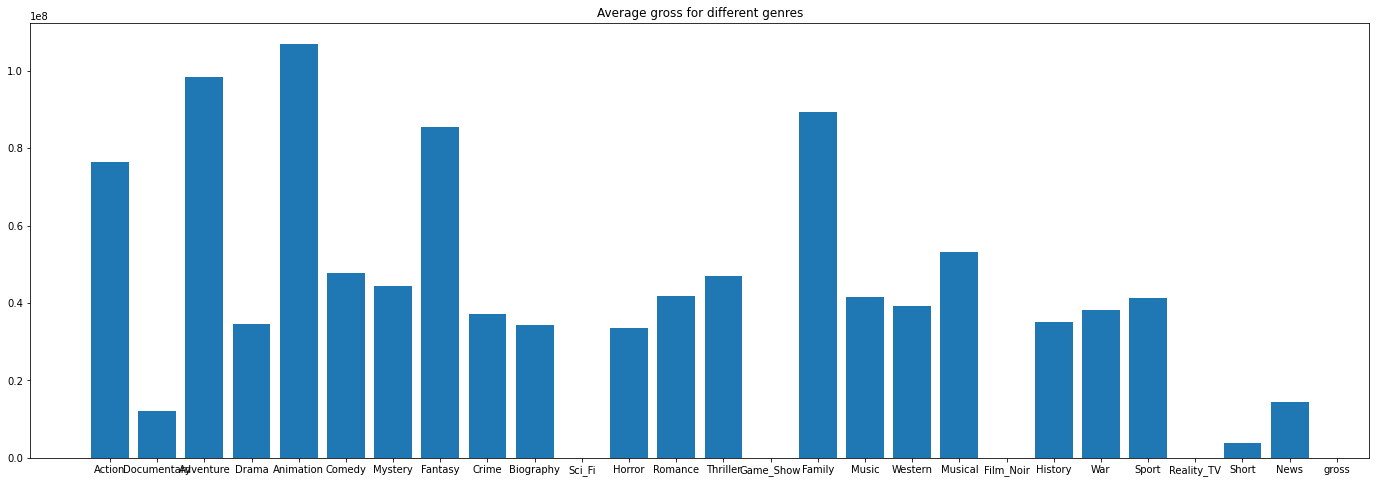

In [39]:
means = []
for column in genres_df.columns:
    means.append(genres_df.loc[genres_df[column] == 1, "gross"].mean())

    
fig, ax = plt.subplots(figsize=(24, 8))
plt.bar(x=genres_df.columns, height=means)
plt.title("Average gross for different genres")
plt.show()

In [40]:
genres_df.corrwith(genres_df.gross).sort_values(ascending = False)

gross          1.000000
Adventure      0.359086
Action         0.226441
Family         0.213204
Fantasy        0.206023
Animation      0.194067
Musical        0.011266
News          -0.007728
Comedy        -0.009179
Short         -0.014274
Thriller      -0.014431
Western       -0.017128
Mystery       -0.019385
Sport         -0.021211
Music         -0.027734
War           -0.030711
History       -0.039047
Romance       -0.052951
Biography     -0.053399
Horror        -0.072122
Crime         -0.078227
Documentary   -0.079425
Drama         -0.209524
Sci_Fi              NaN
Game_Show           NaN
Film_Noir           NaN
Reality_TV          NaN
dtype: float64

### Model with facebook_likes and all genre dummies

In [41]:
model = smf.ols(formula = 'gross~movie_facebook_likes+cast_total_facebook_likes+' + '+'.join([str(x) for x in genre_list]), data = movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     80.17
Date:                Sat, 11 Mar 2023   Prob (F-statistic):          2.21e-320
Time:                        12:26:01   Log-Likelihood:                -80141.
No. Observations:                4159   AIC:                         1.603e+05
Df Residuals:                    4134   BIC:                         1.605e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.329e+07   2.92e+06     11.385      0.000    2.76e+07     3.9e+07
movie_facebook_likes       1014.5736     44.228     22.940      0.000     927.864    1101.284
cast_total_facebook_likes   565.5752     48.998     11.543      0.000     469.513     661.637
Action                     1.825e+07   2.54e+06      7.184      0.000    1.33e+07    2.32e+07
Documentary               -2.385e+07   6.44e+06     -3.702      0.000   -3.65e+07   -1.12e+07
Adventure                  2.757e+07   2.75e+06     10.040      0.000    2.22e+07     3.3e+07
Drama                     -1.726e+07   2.23e+06     -7.733      0.000   -2.16e+07   -1.29e+07
Animation                  2.005e+07   5.03e+06      3.987      0.000    1.02e+07    2.99e+07
Comedy                    -4.862e+06   2.29e+06     -2.126      0.034   -9.35e+06   -3.79e+05
Mystery                    3.471e+06   3.22e+06      1.077      0.282   -2.85e+06    9.79e+06
Fantasy                    1.116e+07   2.95e+06      3.783      0.000    5.38e+06    1.69e+07
Crime                     -5.803e+06   2.59e+06     -2.238      0.025   -1.09e+07   -7.19e+05
Biography                 -3.408e+06      4e+06     -0.852      0.394   -1.13e+07    4.44e+06
Sci_Fi                    -4.254e-07   6.01e-07     -0.707      0.479    -1.6e-06    7.54e-07
Horror                    -1.506e+07   3.44e+06     -4.374      0.000   -2.18e+07   -8.31e+06
Romance                    4.411e+06   2.27e+06      1.940      0.052   -4.57e+04    8.87e+06
Thriller                  -3.647e+06   2.54e+06     -1.438      0.150   -8.62e+06    1.33e+06
Game_Show                 -7.178e-08   7.62e-08     -0.943      0.346   -2.21e-07    7.75e-08
Family                     1.897e+07   3.68e+06      5.158      0.000    1.18e+07    2.62e+07
Music                      4.657e+05   4.52e+06      0.103      0.918    -8.4e+06    9.33e+06
Western                   -1.756e+07   7.05e+06     -2.490      0.013   -3.14e+07   -3.73e+06
Musical                   -2.833e+06   7.05e+06     -0.402      0.688   -1.66e+07     1.1e+07
Film_Noir                  1.892e-08   1.91e-08      0.993      0.321   -1.85e-08    5.63e-08
History                   -1.094e+06   5.08e+06     -0.215      0.830   -1.11e+07    8.87e+06
War                        -3.37e+06   4.78e+06     -0.705      0.481   -1.27e+07       6e+06
Sport                      4.657e+06   4.64e+06      1.003      0.316   -4.44e+06    1.38e+07
Reality_TV                         0          0        nan        nan           0           0
Short                     -4.012e+07   4.04e+07     -0.994      0.320   -1.19e+08     3.9e+07
News                      -7.409e+05   5.71e+07     -0.013      0.990   -1.13e+08    1.11e+08
===========================================================================

In [42]:
#MAE
predictions = model.predict(test)

#Computing MAE on test data
(np.abs(test.gross - predictions)).mean()

35452892.645435564

### Attempting to transform budget variable

In [45]:
model = smf.ols(formula = 'np.log(gross)~budget+np.log(budget)', data = movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     1049.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:26:41   Log-Likelihood:                -7798.6
No. Observations:                3891   AIC:                         1.560e+04
Df Residuals:                    3888   BIC:                         1.562e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8896      0.322      5.869      0.000       1.258       2.521
budget          -1.01e-09   1.34e-10     -7.544      0.000   -1.27e-09   -7.47e-10
np.log(budget)     0.8785      0.019     45.608      0.000       0.841       0.916
==============================================================================
Omnibus:                     1037.630   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3202.066
Skew:                          -1.357   Prob(JB):                         0.00
Kurtosis:                       6.519   Cond. No.                     2.54e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
predictions = model.predict(test)

#Computing MAE on test data
(np.abs(test.gross - np.exp(predictions))).mean()

31357714.013893235

<AxesSubplot:>

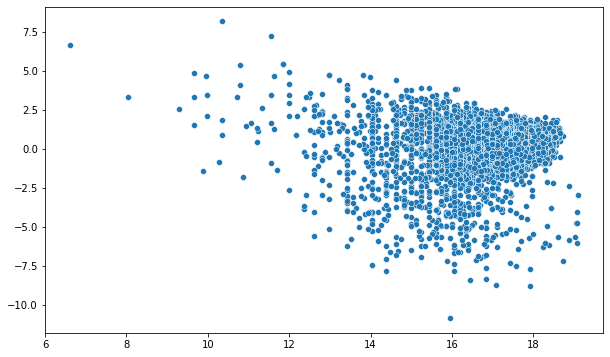

In [47]:
sns.scatterplot(x = model.fittedvalues, y = model.resid)

In [48]:
model = smf.ols('np.log(gross)~movie_facebook_likes+cast_total_facebook_likes+budget+np.log(budget)', data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     568.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:26:52   Log-Likelihood:                -7741.0
No. Observations:                3891   AIC:                         1.549e+04
Df Residuals:                    3886   BIC:                         1.552e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5765      0.324      7.943      0.000       1.941       3.212
movie_facebook_likes       1.279e-05   1.38e-06      9.258      0.000    1.01e-05    1.55e-05
cast_total_facebook_likes  6.078e-06   1.56e-06      3.900      0.000    3.02e-06    9.13e-06
budget                    -1.001e-09   1.32e-10     -7.583      0.000   -1.26e-09   -7.42e-10
np.log(budget)                0.8263      0.020     41.982      0.000       0.788       0.865
==============================================================================
Omnibus:                     1037.241   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3169.582
Skew:                          -1.361   Prob(JB):                         0.00
Kurtosis:                       6.485   Cond. No.                     2.60e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
predictions = model.predict(test)

#Computing MAE on test data
(np.abs(test.gross - np.exp(predictions))).mean()

41546028.71394608

<AxesSubplot:>

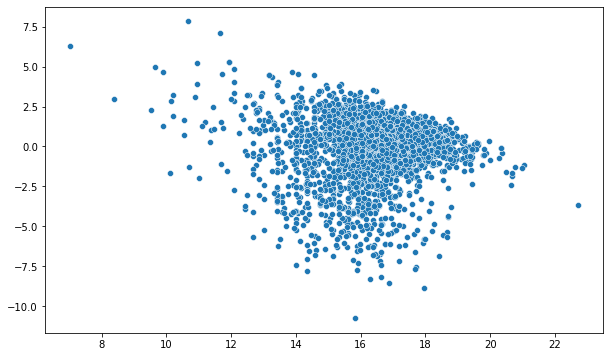

In [50]:
sns.scatterplot(x = model.fittedvalues, y = model.resid)

In [51]:
model = smf.ols('np.log(gross)~movie_facebook_likes+cast_total_facebook_likes+budget+np.log(budget)+' + '+'.join([str(x) for x in genre_list]), data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(gross)   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:27:07   Log-Likelihood:                -7657.4
No. Observations:                3891   AIC:                         1.537e+04
Df Residuals:                    3865   BIC:                         1.553e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.1222      0.368      8.489      0.000       2.401       3.843
movie_facebook_likes        1.37e-05   1.38e-06      9.909      0.000     1.1e-05    1.64e-05
cast_total_facebook_likes  6.903e-06   1.54e-06      4.490      0.000    3.89e-06    9.92e-06
budget                    -9.794e-10    1.3e-10     -7.524      0.000   -1.23e-09   -7.24e-10
np.log(budget)                0.7913      0.022     35.555      0.000       0.748       0.835
Action                        0.0389      0.081      0.479      0.632      -0.120       0.198
Documentary                  -0.3242      0.231     -1.404      0.160      -0.777       0.129
Adventure                     0.1267      0.087      1.464      0.143      -0.043       0.296
Drama                        -0.3338      0.071     -4.695      0.000      -0.473      -0.194
Animation                    -0.1522      0.157     -0.967      0.334      -0.461       0.156
Comedy                        0.1233      0.073      1.689      0.091      -0.020       0.266
Mystery                       0.1272      0.101      1.257      0.209      -0.071       0.326
Fantasy                      -0.1217      0.092     -1.323      0.186      -0.302       0.059
Crime                        -0.2002      0.082     -2.444      0.015      -0.361      -0.040
Biography                     0.2197      0.128      1.720      0.086      -0.031       0.470
Sci_Fi                     9.549e-14   9.85e-14      0.970      0.332   -9.76e-14    2.89e-13
Horror                        0.3750      0.109      3.448      0.001       0.162       0.588
Romance                       0.1586      0.073      2.186      0.029       0.016       0.301
Thriller                      0.0970      0.080      1.215      0.224      -0.060       0.254
Game_Show                 -1.252e-13   1.29e-13     -0.970      0.332   -3.78e-13    1.28e-13
Family                        0.5027      0.116      4.317      0.000       0.274       0.731
Music                         0.4430      0.149      2.972      0.003       0.151       0.735
Western                      -0.2077      0.224     -0.926      0.355      -0.648       0.232
Musical                      -0.4995      0.227     -2.200      0.028      -0.945      -0.054
Film_Noir                 -7.217e-16   6.61e-16     -1.091      0.275   -2.02e-15    5.75e-16
History                      -0.3071      0.161     -1.912      0.056      -0.622       0.008
War                          -0.5019      0.152     -3.312      0.001      -0.799      -0.205
Sport                         0.1473      0.150      0.984      0.325      -0.146       0.441
Reality_TV                         0          0        nan        nan           0           0
Short                         0.5777      1.239      0.466      0.641      

In [53]:
predictions = model.predict(test)

#Computing MAE on test data
(np.abs(test.gross - np.exp(predictions))).mean()

41686954.88227355

In [54]:
len(movies)

5043

In [55]:
movies2 = movies.dropna()
movies2 = movies2.reset_index()
movies2['log_gross'] = np.log(movies.gross)

In [56]:
import statsmodels.regression.linear_model as sm
from sklearn.preprocessing import PolynomialFeatures
X = movies2[['movie_facebook_likes', 'cast_total_facebook_likes', 'budget']]
Y = movies2['gross']

feat = PolynomialFeatures(3, interaction_only = False)
X = feat.fit_transform(X)
X = pd.DataFrame(data = X, columns = feat.get_feature_names_out())

model = sm.OLS(endog = Y, exog = X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                      -0.165
Model:                            OLS   Adj. R-squared:                 -0.168
Method:                 Least Squares   F-statistic:                    -66.38
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               1.00
Time:                        12:27:19   Log-Likelihood:                -73481.
No. Observations:                3756   AIC:                         1.470e+05
Df Residuals:                    3747   BIC:                         1.470e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
1                                                      2.245e-22   6.62e-23      3.390      0.001    9.47e-23    3.54e-22
movie_facebook_likes                                  -4.698e-11   3.15e-11     -1.493      0.136   -1.09e-10    1.47e-11
cast_total_facebook_likes                             -4.609e-17   1.75e-17     -2.635      0.008   -8.04e-17   -1.18e-17
budget                                                 1.147e-14   2.88e-15      3.987      0.000    5.83e-15    1.71e-14
movie_facebook_likes^2                                 1.254e-12   4.15e-13      3.020      0.003     4.4e-13    2.07e-12
movie_facebook_likes cast_total_facebook_likes         7.344e-13   2.29e-13      3.211      0.001    2.86e-13    1.18e-12
movie_facebook_likes budget                            1.446e-10   1.55e-11      9.302      0.000    1.14e-10    1.75e-10
cast_total_facebook_likes^2                            5.412e-13   1.67e-13      3.244      0.001    2.14e-13    8.68e-13
cast_total_facebook_likes budget                       1.546e-10   4.04e-11      3.826      0.000    7.54e-11    2.34e-10
budget^2                                              -3.111e-11   7.22e-12     -4.310      0.000   -4.53e-11    -1.7e-11
movie_facebook_likes^3                                -6.031e-08   6.11e-09     -9.874      0.000   -7.23e-08   -4.83e-08
movie_facebook_likes^2 cast_total_facebook_likes       9.788e-08   3.12e-08      3.132      0.002    3.66e-08    1.59e-07
movie_facebook_likes^2 budget                          1.496e-10   1.11e-11     13.448      0.000    1.28e-10    1.71e-10
movie_facebook_likes cast_total_facebook_likes^2        3.93e-08   1.23e-08      3.201      0.001    1.52e-08    6.34e-08
movie_facebook_likes cast_total_facebook_likes budget -2.175e-10   3.68e-11     -5.918      0.000    -2.9e-10   -1.45e-10
movie_facebook_likes budget^2                         -2.043e-14   2.35e-15     -8.678      0.000    -2.5e-14   -1.58e-14
cast_total_facebook_likes^3                           -3.381e-09   8.48e-10     -3.985      0.000   -5.04e-09   -1.72e-09
cast_total_facebook_likes^2 budget                     8.746e-11   2.01e-11      4.347      0.000     4.8e-11    1.27e-10
cast_total_facebook_likes budget^2                     1.023e-13   7.54e-15     13.578      0.000    8.76e-14    1.17e-13
budget^3                                               4.388e-21   8.28e-22      5.299      0.000    2.76e-21    6.01e-21
==============================================================================
Omnibus:                     1736.675   Durbin-Watson:                   0.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36786.880
Skew:                           1.699   

# Lila

# DURATION

In [58]:
movies['duration'].argmax();
movies.iloc[1710,:]; #max length is 511 
movies['duration'].argmin();
movies.iloc[1947,:]; #min length is 7 

<AxesSubplot:xlabel='duration', ylabel='gross'>

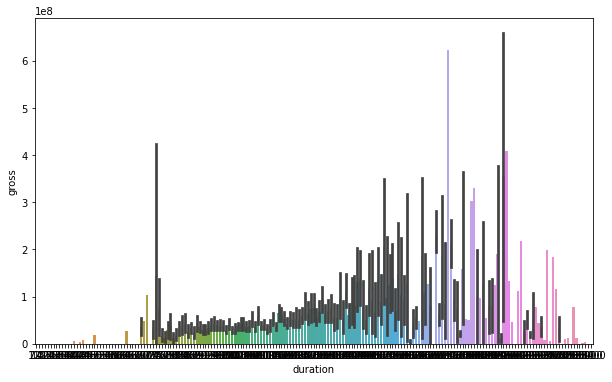

In [59]:
plt.rcParams["figure.figsize"] = (10,6)
sns.barplot(x ='duration',y = 'gross',data = movies)

# Binning Duration w Krish's Reccommendations

In [60]:
cut_bins = [0, 114, 122, 134, 511]
movies['binned_dur'] = pd.cut(movies['duration'], bins=cut_bins)

Text(0, 0.5, 'Gross')

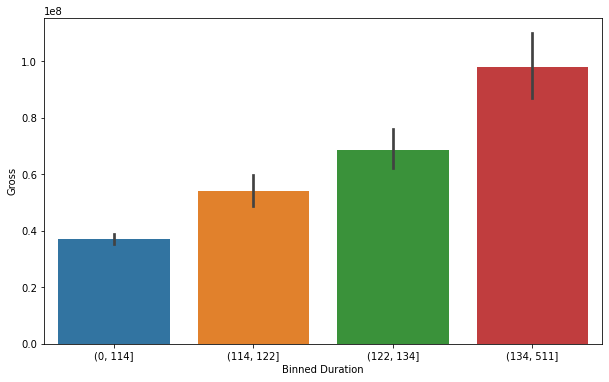

In [61]:
sns.barplot(x ='binned_dur',y = 'gross',data = movies)
plt.xlabel('Binned Duration')
plt.ylabel('Gross')


In [62]:
def var_transform(data):
    data['duration_binned'] = pd.cut(data['duration'], bins=cut_bins)
    dum = pd.get_dummies(data.duration_binned,drop_first = True)
    dum.columns = ['duration'+str(x) for x in range(1,len(cut_bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

train_transformed = var_transform(train)
train_transformed

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,History,War,Sport,Reality_TV,Short,News,duration_binned,duration1,duration2,duration3
4198,Color,Randall Miller,1.0,34.0,19.0,362.0,Elden Henson,882.0,333658.0,Comedy|Family|Musical|Romance|Short,...,0,0,0,0,1,0,"(0, 114]",0,0,0
338,Color,Andrew Stanton,301.0,100.0,475.0,799.0,Stephen Root,1000.0,380838870.0,Adventure|Animation|Comedy|Family,...,0,0,0,0,0,0,"(0, 114]",0,0,0
4626,Color,D. Stevens,6.0,94.0,6.0,0.0,Pierre Dulat,92.0,NaN,Drama|Thriller,...,0,0,0,0,0,0,"(0, 114]",0,0,0
2542,Color,Sidney Lumet,79.0,129.0,0.0,359.0,James Mason,844.0,54000000.0,Drama,...,0,0,0,0,0,0,"(122, 134]",0,1,0
1353,Color,John Pasquin,55.0,98.0,11.0,466.0,Ken Marino,854.0,22770864.0,Comedy|Drama,...,0,0,0,0,0,0,"(0, 114]",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,Color,Woody Allen,66.0,89.0,11000.0,45.0,John Beck,11000.0,NaN,Comedy|Sci-Fi,...,0,0,0,0,0,0,"(0, 114]",0,0,0
4945,Color,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,...,0,0,0,0,0,0,"(0, 114]",0,0,0
3742,Color,Mickey Liddell,74.0,82.0,7.0,664.0,Randy Wayne,1000.0,13350177.0,Drama|Horror|Thriller,...,0,0,0,0,0,0,"(0, 114]",0,0,0
2785,Color,Wes Craven,34.0,100.0,0.0,364.0,W. Earl Brown,723.0,19900000.0,Comedy|Fantasy|Horror|Romance,...,0,0,0,0,0,0,"(0, 114]",0,0,0


In [63]:
model = smf.ols(formula = 'gross~' + '+'.join(['duration'+str(x) for x in range(1,4)]), data = train_transformed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     92.10
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.99e-57
Time:                        12:28:43   Log-Likelihood:                -64551.
No. Observations:                3325   AIC:                         1.291e+05
Df Residuals:                    3321   BIC:                         1.291e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    3.81e+07   1.37e+06     27.732      0.000    3.54e+07    4.08e+07
duration1   1.478e+07   3.62e+06      4.079      0.000    7.68e+06    2.19e+07
duration2   2.976e+07   3.77e+06      7.888      0.000    2.24e+07    3.72e+07
duration3   5.916e+07   3.82e+06     15.483      0.000    5.17e+07    6.67e+07
==============================================================================
Omnibus:                     1934.812   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19400.837
Skew:                           2.633   Prob(JB):                         0.00
Kurtosis:                      13.598   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
model = smf.ols('gross~movie_facebook_likes+cast_total_facebook_likes+director_facebook_likes+'+ '+'.join(['duration'+str(x) for x in range(1,4)]), data=train_transformed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     144.0
Date:                Sat, 11 Mar 2023   Prob (F-statistic):          1.17e-162
Time:                        12:28:45   Log-Likelihood:                -64260.
No. Observations:                3323   AIC:                         1.285e+05
Df Residuals:                    3316   BIC:                         1.286e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   2.65e+07    1.4e+06     18.998      0.000    2.38e+07    2.92e+07
movie_facebook_likes       1035.4058     56.226     18.415      0.000     925.165    1145.646
cast_total_facebook_likes   540.6592     55.972      9.659      0.000     430.916     650.403
director_facebook_likes    1286.6332    371.921      3.459      0.001     557.414    2015.852
duration1                  8.673e+06   3.38e+06      2.569      0.010    2.05e+06    1.53e+07
duration2                  1.629e+07   3.55e+06      4.586      0.000    9.33e+06    2.33e+07
duration3                  4.031e+07   3.67e+06     10.979      0.000    3.31e+07    4.75e+07
==============================================================================
Omnibus:                     1679.164   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14032.381
Skew:                           2.251   Prob(JB):                         0.00
Kurtosis:                      12.004   Cond. No.                     9.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
test_transformed = var_transform(test)
test_transformed

#MAE

predictions = model.predict(test_transformed)

#Computing MAE on test data
(np.abs(test_transformed.gross - predictions)).mean()

39230172.87603779

In [66]:
model = smf.ols('gross~budget+np.sqrt(budget)+movie_facebook_likes+cast_total_facebook_likes+director_facebook_likes+'+ '+'.join(['duration'+str(x) for x in range(1,4)]), data=train_transformed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     237.6
Date:                Sat, 11 Mar 2023   Prob (F-statistic):          3.39e-315
Time:                        12:29:20   Log-Likelihood:                -59855.
No. Observations:                3112   AIC:                         1.197e+05
Df Residuals:                    3103   BIC:                         1.198e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.627e+07   1.99e+06     -8.166      0.000   -2.02e+07   -1.24e+07
budget                       -0.1154      0.006    -19.317      0.000      -0.127      -0.104
np.sqrt(budget)            1.106e+04    375.439     29.457      0.000    1.03e+04    1.18e+04
movie_facebook_likes        763.5448     51.824     14.734      0.000     661.933     865.157
cast_total_facebook_likes   298.4510     51.503      5.795      0.000     197.468     399.434
director_facebook_likes    1100.0149    339.097      3.244      0.001     435.137    1764.892
duration1                  8.272e+05   3.15e+06      0.263      0.793   -5.35e+06       7e+06
duration2                 -1.646e+06   3.36e+06     -0.490      0.624   -8.23e+06    4.94e+06
duration3                  1.823e+07   3.45e+06      5.279      0.000    1.15e+07     2.5e+07
==============================================================================
Omnibus:                     1393.752   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13539.096
Skew:                           1.874   Prob(JB):                         0.00
Kurtosis:                      12.506   Cond. No.                     1.00e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
test_transformed = var_transform(test)
test_transformed

#MAE

predictions = model.predict(test_transformed)

#Computing MAE on test data
(np.abs(test_transformed.gross - predictions)).mean()

33023615.74660043

In [68]:
train_transformed = var_transform(train)
train_transformed

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,History,War,Sport,Reality_TV,Short,News,duration_binned,duration1,duration2,duration3
4198,Color,Randall Miller,1.0,34.0,19.0,362.0,Elden Henson,882.0,333658.0,Comedy|Family|Musical|Romance|Short,...,0,0,0,0,1,0,"(0, 114]",0,0,0
338,Color,Andrew Stanton,301.0,100.0,475.0,799.0,Stephen Root,1000.0,380838870.0,Adventure|Animation|Comedy|Family,...,0,0,0,0,0,0,"(0, 114]",0,0,0
4626,Color,D. Stevens,6.0,94.0,6.0,0.0,Pierre Dulat,92.0,NaN,Drama|Thriller,...,0,0,0,0,0,0,"(0, 114]",0,0,0
2542,Color,Sidney Lumet,79.0,129.0,0.0,359.0,James Mason,844.0,54000000.0,Drama,...,0,0,0,0,0,0,"(122, 134]",0,1,0
1353,Color,John Pasquin,55.0,98.0,11.0,466.0,Ken Marino,854.0,22770864.0,Comedy|Drama,...,0,0,0,0,0,0,"(0, 114]",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,Color,Woody Allen,66.0,89.0,11000.0,45.0,John Beck,11000.0,NaN,Comedy|Sci-Fi,...,0,0,0,0,0,0,"(0, 114]",0,0,0
4945,Color,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,...,0,0,0,0,0,0,"(0, 114]",0,0,0
3742,Color,Mickey Liddell,74.0,82.0,7.0,664.0,Randy Wayne,1000.0,13350177.0,Drama|Horror|Thriller,...,0,0,0,0,0,0,"(0, 114]",0,0,0
2785,Color,Wes Craven,34.0,100.0,0.0,364.0,W. Earl Brown,723.0,19900000.0,Comedy|Fantasy|Horror|Romance,...,0,0,0,0,0,0,"(0, 114]",0,0,0


In [74]:
model = smf.ols('gross~budget+np.sqrt(budget)+movie_facebook_likes+cast_total_facebook_likes+director_facebook_likes+Action+Adventure+Family+Fantasy+Animation+' + '+'.join(['duration'+str(x) for x in range(1,4)]), data=train_transformed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     165.3
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:31:58   Log-Likelihood:                -59779.
No. Observations:                3112   AIC:                         1.196e+05
Df Residuals:                    3098   BIC:                         1.197e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.467e+07   1.97e+06     -7.457      0.000   -1.85e+07   -1.08e+07
budget                       -0.0916      0.006    -14.559      0.000      -0.104      -0.079
np.sqrt(budget)            8682.2531    434.432     19.985      0.000    7830.450    9534.056
movie_facebook_likes        775.2791     50.881     15.237      0.000     675.515     875.043
cast_total_facebook_likes   322.4669     50.342      6.406      0.000     223.760     421.173
director_facebook_likes    1281.7415    331.597      3.865      0.000     631.569    1931.914
Action                     3.197e+06   2.54e+06      1.260      0.208   -1.78e+06    8.17e+06
Adventure                  1.615e+07   2.87e+06      5.627      0.000    1.05e+07    2.18e+07
Family                     1.978e+07   3.94e+06      5.018      0.000     1.2e+07    2.75e+07
Fantasy                    6.092e+06   3.09e+06      1.974      0.048    4.13e+04    1.21e+07
Animation                  1.455e+07   5.44e+06      2.676      0.007    3.89e+06    2.52e+07
duration1                  5.892e+06   3.11e+06      1.891      0.059   -2.16e+05     1.2e+07
duration2                  3.651e+06   3.34e+06      1.093      0.275    -2.9e+06    1.02e+07
duration3                  2.497e+07   3.46e+06      7.209      0.000    1.82e+07    3.18e+07
==============================================================================
Omnibus:                     1362.399   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12987.320
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                      12.317   Cond. No.                     1.56e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
test_transformed = var_transform(test)
test_transformed

#MAE
predictions = model.predict(test_transformed)

#Computing MAE on test data
(np.abs(test_transformed.gross - predictions)).mean()

32452864.59144134

<AxesSubplot:xlabel='title_year'>

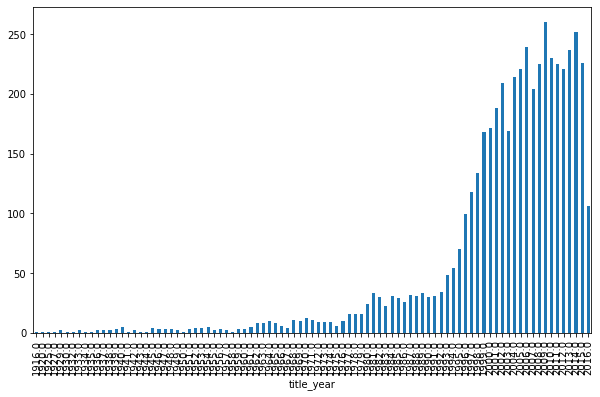

In [76]:
#calculate sum of points for each team
df_groups = movies.groupby('title_year')['movie_title'].count()

#create bar plot by group
df_groups.plot(kind='bar')

#movies2[movies2.title_year < 2004]

## FINAL MODEL IN PRES

In [77]:
model = smf.ols('gross~budget+np.sqrt(budget)+movie_facebook_likes+cast_total_facebook_likes+director_facebook_likes+(title_year*(Action+Adventure+Family+Fantasy+Animation))+' + '+'.join(['duration'+str(x) for x in range(1,4)]), data=train_transformed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     119.9
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:32:13   Log-Likelihood:                -59740.
No. Observations:                3112   AIC:                         1.195e+05
Df Residuals:                    3092   BIC:                         1.196e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.671e+09   2.58e+08      6.468      0.000    1.16e+09    2.18e+09
budget                       -0.1000      0.006    -15.713      0.000      -0.112      -0.087
np.sqrt(budget)            9525.2657    450.174     21.159      0.000    8642.596    1.04e+04
movie_facebook_likes        913.3745     53.463     17.084      0.000     808.548    1018.201
cast_total_facebook_likes   345.2497     49.861      6.924      0.000     247.486     443.013
director_facebook_likes    1072.9396    329.221      3.259      0.001     427.426    1718.453
title_year                -8.431e+05   1.29e+05     -6.533      0.000    -1.1e+06    -5.9e+05
Action                      1.06e+09   5.01e+08      2.115      0.035    7.71e+07    2.04e+09
Adventure                 -1.328e+09   4.96e+08     -2.681      0.007    -2.3e+09   -3.57e+08
Family                     2.704e+07   7.37e+08      0.037      0.971   -1.42e+09    1.47e+09
Fantasy                    1.358e+09   6.24e+08      2.176      0.030    1.34e+08    2.58e+09
Animation                 -1.629e+09   1.03e+09     -1.581      0.114   -3.65e+09    3.91e+08
title_year:Action         -5.282e+05    2.5e+05     -2.110      0.035   -1.02e+06   -3.75e+04
title_year:Adventure       6.702e+05   2.48e+05      2.708      0.007    1.85e+05    1.16e+06
title_year:Family         -3998.2967   3.68e+05     -0.011      0.991   -7.25e+05    7.17e+05
title_year:Fantasy        -6.753e+05   3.12e+05     -2.168      0.030   -1.29e+06   -6.46e+04
title_year:Animation       8.193e+05   5.14e+05      1.594      0.111   -1.88e+05    1.83e+06
duration1                  3.996e+06   3.09e+06      1.291      0.197   -2.07e+06    1.01e+07
duration2                  2.066e+05   3.34e+06      0.062      0.951   -6.34e+06    6.75e+06
duration3                  1.845e+07   3.54e+06      5.209      0.000    1.15e+07    2.54e+07
==============================================================================
Omnibus:                     1334.810   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13261.665
Skew:                           1.766   Prob(JB):                         0.00
Kurtosis:                      12.476   Cond. No.                     3.01e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
test_transformed = var_transform(test)
test_transformed

#MAE
predictions = model.predict(test_transformed)

#Computing MAE on test data
(np.abs(test_transformed.gross - predictions)).mean()

32243359.882436555

## FINAL MODEL IN PRES^^

# This was my duration binning, pre krish conversation

In [51]:
#Binning duration
binned_duration = pd.qcut(movies['duration'],10,retbins=True)
movies['duration_binned'] = binned_duration[0]

<AxesSubplot:xlabel='duration_binned', ylabel='gross'>

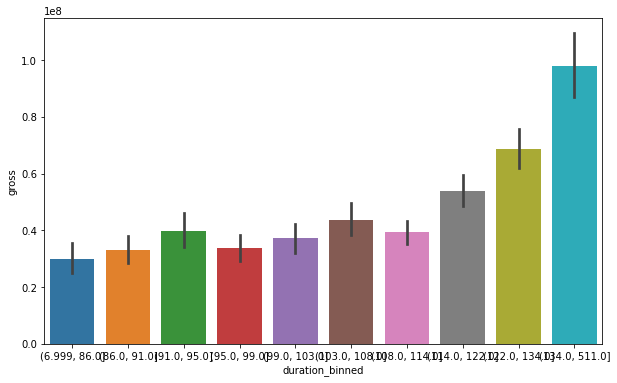

In [53]:
#Visualizing percentage of people having diabetes with increasing Age (or Age bins)
#Upward, linear trend. Good!

sns.barplot(x ='duration_binned',y = 'gross',data = movies)

In [54]:
def var_transform(data):
    binned_duration = pd.qcut(data['duration'],10,retbins=True)
    bins = binned_duration[1]
    data['duration_binned'] = pd.cut(data['duration'],bins = bins)
    dum = pd.get_dummies(data.duration_binned,drop_first = True)
    dum.columns = ['duration'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

movies_transformed = var_transform(movies)

movies_transformed

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,duration_binned,duration1,duration2,duration3,duration4,duration5,duration6,duration7,duration8,duration9
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,"(134.0, 511.0]",0,0,0,0,0,0,0,0,1
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,"(134.0, 511.0]",0,0,0,0,0,0,0,0,1
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,"(134.0, 511.0]",0,0,0,0,0,0,0,0,1
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,"(134.0, 511.0]",0,0,0,0,0,0,0,0,1
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,"(86.0, 91.0]",1,0,0,0,0,0,0,0,0
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,"(7.0, 86.0]",0,0,0,0,0,0,0,0,0
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,"(7.0, 86.0]",0,0,0,0,0,0,0,0,0
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,"(99.0, 103.0]",0,0,0,1,0,0,0,0,0


In [55]:
model = smf.ols(formula = 'gross~' + '+'.join(['duration'+str(x) for x in range(1,10)]), data = movies_transformed).fit()
#model = smf.ols('gross~duration', data=movies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     42.16
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           8.76e-73
Time:                        22:56:57   Log-Likelihood:                -80754.
No. Observations:                4159   AIC:                         1.615e+05
Df Residuals:                    4149   BIC:                         1.616e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.967e+07   3.72e+06      7.976      0.000    2.24e+07     3.7e+07
duration1   3.429e+06   4.98e+06      0.688      0.491   -6.34e+06    1.32e+07
duration2   1.017e+07   5.02e+06      2.027      0.043    3.35e+05       2e+07
duration3    4.16e+06   4.92e+06      0.845      0.398   -5.49e+06    1.38e+07
duration4   7.648e+06    4.9e+06      1.560      0.119   -1.96e+06    1.73e+07
duration5   1.413e+07   4.81e+06      2.936      0.003    4.69e+06    2.36e+07
duration6   9.654e+06   4.84e+06      1.994      0.046    1.62e+05    1.91e+07
duration7   2.433e+07   4.78e+06      5.085      0.000    1.49e+07    3.37e+07
duration8   3.901e+07   4.86e+06      8.031      0.000    2.95e+07    4.85e+07
duration9   6.823e+07   4.91e+06     13.883      0.000    5.86e+07    7.79e+07
==============================================================================
Omnibus:                     2640.669   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36251.821
Skew:                           2.841   Prob(JB):                         0.00
Kurtosis:                      16.301   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='duration'>

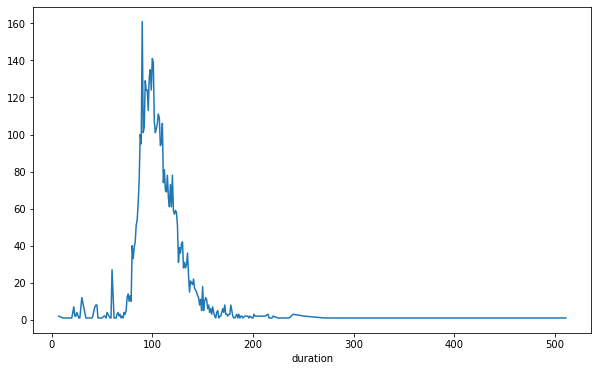

In [56]:
#Most movies are between 75 and 150
data_groupby_duration = movies.groupby(['duration'])['movie_title'].count()
data_groupby_duration.plot()

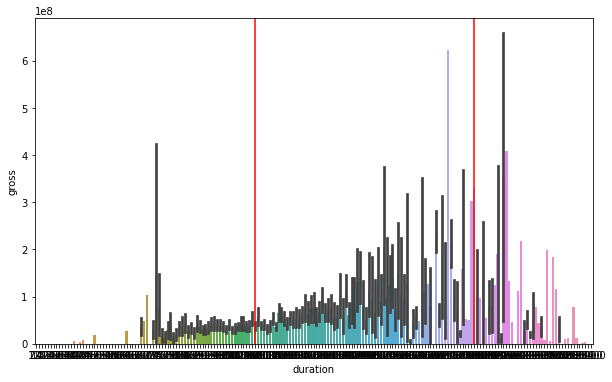

In [57]:
#subset_movies = movies.loc[(movies['duration']>75) &( movies['duration']<150), :]
sns.barplot(x ='duration',y = 'gross',data = movies)
plt.axvline(75, 0,400, color='red') #the tate age
plt.axvline(150, 0,400, color='red') #the tate age


In [58]:
#Only considering languages that appear over 10 times in the dataset
movies2 = movies.dropna()
movies2['language_general'] = movies2['language'].apply(lambda x: "English" if "English" in x
                                                                else "French" if "French" in x
                                                                else "Spanish" if "Spanish" in x
                                                                else "Hindi" if "Hindi" in x
                                                                else "Mandarin" if 'Mandarin' in x
                                                                else 'other')


/var/folders/9_/0dzs7rnd23j760gb74hwn0_80000gn/T/ipykernel_70583/3228729606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies2['language_general'] = movies2['language'].apply(lambda x: "English" if "English" in x


<AxesSubplot:xlabel='language_general', ylabel='gross'>

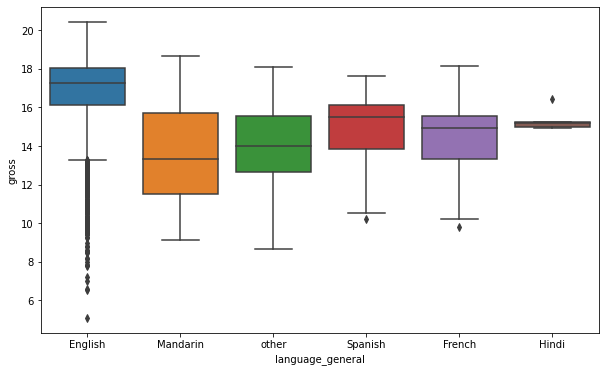

In [59]:
sns.boxplot(x = 'language_general', y = np.log(movies2.gross), data = movies2)
